# Model 2: Review Baseline Example
Here, we will use all of the encoded data to create a new model using numerical features.

In [1]:
# ===============LICENSE_START=======================================================
# Apache-2.0
# ===================================================================================
# Copyright (C) 2019 AT&T Intellectual Property  All rights reserved.
# ===================================================================================
# This software file is distributed by AT&T
# under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ===============LICENSE_END=========================================================

import pandas as pd  # data read
from sklearn import preprocessing  # data ETL
import os,sys  # file checks
import dill as pickle   # serialize functions and data as compressed binary 
import gzip  # compression 
import yaml   # configuration file
from matplotlib import pyplot as plt

import util_review
import util_train

# for interactive graphs
# %matplotlib notebook  

config_path = 'config.yaml'
if not os.path.isfile(config_path):
    print("Sorry, can't find the configuration file {}, aborting.".format(config_path))
    sys.exit(-1)
config = yaml.safe_load(open(config_path))

In [2]:
# read our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'rb') as f:
    df = pickle.load(f)
# read our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_preproc"], 'rb') as f:
    etl = pickle.load(f)   # note that we use local variable 'etl' instead of 'models'
    
print(df.keys())
print("Loaded Dimensionality: Training({}), RawTest({})".format(
    df["X_train"].shape, df["X_test"].shape ))
print(df["X_train"].columns)
print(df["X_test"].columns)

df["X_train"].sample(4)


dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'X_train_raw'])
Loaded Dimensionality: Training((20299, 1115)), RawTest((5075, 6))
Index(['re_10', 're_34', 're_3m', 're_able', 're_actually', 're_address',
       're_adhesive', 're_amazon', 're_avery', 're_away',
       ...
       'cat_voip', 'cat_wall calendars', 'cat_wirebound notebooks',
       'cat_wooden colored pencils', 'cat_wrist rests',
       'cat_writing & correction supplies', 't_DOW', 't_month', 't_year',
       't_day'],
      dtype='object', length=1115)
Index(['helpful', 'reviewText', 'summary', 'unixReviewTime', 'categories',
       'description'],
      dtype='object')


,re_10,re_34,re_3m,re_able,re_actually,re_address,re_adhesive,re_amazon,re_avery,re_away,...,cat_voip,cat_wall calendars,cat_wirebound notebooks,cat_wooden colored pencils,cat_wrist rests,cat_writing & correction supplies,t_DOW,t_month,t_year,t_day
row_id,,,,,,,,,,,,,,,,,,,,,
4389,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.6,-1.0,-1.133333
14405,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.2,-0.5,0.066667
21559,0.0,0.23621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.2,0.5,0.800000
24612,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667,-0.4,1.0,-0.666667


# Preprocessing 
Preprocessing will run through required steps to generate extra columns and normalize (according to inputs) for the underlying predictors to train/evaluate a sample.

In [3]:
# save the FUNCTION and a data example for later use!
df["X_test_enc"] = df["X_test"].copy()
df["X_test_enc"] = etl["fn_preproc"](etl, df["X_test"])

# Performance Evaluation
This quick function will plot the performance of our algorithm by finding the [area under the curve (aka ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

For basic models, a number of sample models from scikit are included as possibilities, like a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and or a [GradientBoostedClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier).  The model utilized is chosen by the configuration file setting `model_type`.

A more advanced model training process is also included called [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).  Here, we use cross validalidation to explore a number of parameter settings (and random starts) to find the best performing model configutation.  This option is also controlled in the configuration file by the parameter `cross_validate` but by default it is disabled because of the expected run time.

Finally, we can use [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) (here [average_precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) as determined by the config setting `scoring`) to more easily compare the performance of different models that we build.  It should be noted that no tunings for either model was done, so it doesn't speak to the overall fitness of one type versus another.

In [4]:
models = util_train.train_model(df["X_train"], df["y_train"], config["training"]["scoring"], 
                                config["training"]["model_type"], config["training"]["cross_validate"], 
                                config["training"]["threads"])


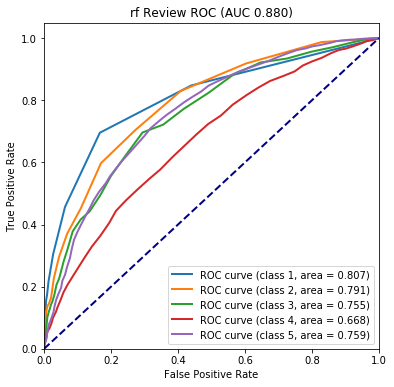

rf AUC: 0.880, trained time: 20.610s


In [5]:
# print performance!
auc_class, fig = util_review.draw_roc(df["X_test_enc"], df["y_test"], 
                                 classifier=models["best"], 
                                 title="{} Review ROC".format(config["training"]["model_type"]))
fig.savefig(config["path"]["figure_classifier"])  # saves the current figure

print("{} AUC: {:0.3f}, trained time: {:0.3f}s".format(config["training"]["model_type"], 
                                                       auc_class, models["time_train"]))


In [6]:
# finally, write out our intermediate data...
# and write out our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_classifier"], 'wb') as f:
    pickle.dump(models, f)
